In [1]:
import numpy as np
import pandas as pd

np.random.seed()
N = 1000  # number of samples

# --------------- Domain 1: Route Planning ---------------
route_planning = pd.DataFrame({
    'origin_x': np.random.uniform(0, 100, N),
    'origin_y': np.random.uniform(0, 100, N),
    'dest_x': np.random.uniform(0, 100, N),
    'dest_y': np.random.uniform(0, 100, N),
    'traffic_density': np.random.uniform(0, 1, N),
    'road_type': np.random.choice([1, 2, 3, 4, 5], N),
})
route_planning['distance'] = np.sqrt(
    (route_planning['dest_x'] - route_planning['origin_x'])**2 +
    (route_planning['dest_y'] - route_planning['origin_y'])**2
)
speed_base = {1:60, 2:50, 3:40, 4:30, 5:20}
route_planning['speed'] = route_planning['road_type'].map(speed_base) * np.random.uniform(0.7, 1.3, N)
route_planning['travel_time'] = (route_planning['distance']/route_planning['speed'])*60*\
                                (1 + route_planning['traffic_density']*np.random.uniform(0.05,0.7,N))

# --------------- Domain 2: Vehicle Assignment ---------------
vehicle_assignment = pd.DataFrame({
    'vehicle_capacity': np.random.randint(50,500,N),
    'battery_level': np.random.uniform(0.2,1.0,N),
    'delivery_size': np.random.randint(5,150,N),
    'vehicle_type': np.random.choice([1,2,3],N),
    'speed_factor': np.random.uniform(0.7,1.2,N),
})
vehicle_assignment['assigned_speed'] = route_planning['speed'] * vehicle_assignment['speed_factor']
vehicle_assignment['load_utilization'] = vehicle_assignment['delivery_size']/vehicle_assignment['vehicle_capacity']

# --------------- Domain 3: Time Scheduling ---------------
time_scheduling = pd.DataFrame({
    'requested_time': np.random.randint(0,24,N),
    'delivery_priority': np.random.randint(1,10,N),
    'customer_patience': np.random.uniform(0,1,N),
})
time_scheduling['delay_probability'] = np.clip(
    (route_planning['travel_time']/60)*(1+vehicle_assignment['load_utilization']*0.7)*np.random.uniform(0.5,1.5,N),
    0,1
)

# --------------- Combine for 2 nodes ----------------
datasets = [route_planning, vehicle_assignment, time_scheduling]
DATA_MATRIX = np.hstack([df.values for df in datasets])
DATA_MATRIX = (DATA_MATRIX - DATA_MATRIX.min(axis=0)) / (np.ptp(DATA_MATRIX, axis=0)+1e-8)

# --------------- Graph-based 2-node Targets ----------------
D_graph = 2
candidate_dims = [8, 5]  # target dimensions per node

def generate_targets_per_node(DATA_MATRIX, candidate_dims, D_graph):
    targets = []
    for node_idx in range(D_graph):
        row = DATA_MATRIX[np.random.randint(0, len(DATA_MATRIX))]
        dim = candidate_dims[node_idx]

        if len(row) >= dim:
            sampled = row[:dim] * np.random.uniform(0.8, 1.2, dim)  # small random scaling
        else:
            pad_values = np.random.uniform(0, 1, dim - len(row))
            sampled = np.concatenate([row, pad_values])

        # non-linear transformation for complexity
        sampled = np.sin(sampled * np.pi) + np.log1p(sampled)
        targets.append({'target': sampled})
    return targets

synthetic_targets = generate_targets_per_node(DATA_MATRIX, candidate_dims, D_graph)

# Check
for i, t in enumerate(synthetic_targets):
    print(f"Node {i} target size: {len(t['target'])}")

# --------------- Combine and Normalize ---------------
DATA_MATRIX = np.hstack([df.values for df in datasets])
DATA_MATRIX = (DATA_MATRIX - DATA_MATRIX.min(axis=0)) / (np.ptp(DATA_MATRIX, axis=0)+1e-8)

# --------------- Graph-based Multi-node Targets ---------------
D_graph = 5  # number of nodes=
candidate_dims =candidate_dims = [8, 6, 4, 3, 6]  # D_graph=5
 # each node has its own target dimension


# ---------------- Combine and normalize ----------------
datasets = [route_planning, time_scheduling,]
dataset_dims = [df.shape[1] for df in datasets]
max_dim = max(dataset_dims)
padded_data = [df.values for df in datasets]

DATA_MATRIX = np.hstack(padded_data)
DATA_MATRIX = (DATA_MATRIX - DATA_MATRIX.min(axis=0)) / (np.ptp(DATA_MATRIX, axis=0)+1e-8)
def generate_targets_per_node(DATA_MATRIX, candidate_dims, D_graph):
    """
    Generate target vectors for each node with its own candidate dimension.

    Parameters:
    - DATA_MATRIX: normalized data array
    - candidate_dims: list of ints, length = D_graph, each specifying the target vector size per node
    - D_graph: number of graph nodes

    Returns:
    - List of dicts: each dict contains the node's target vector under key 'target'
    """
    targets = []
    for node_idx in range(D_graph):
        row = DATA_MATRIX[node_idx % len(DATA_MATRIX)]
        dim = candidate_dims[node_idx]  # get the dim for this node
        if len(row) >= dim:
            sampled = row[:dim]
        else:
            sampled = np.pad(row, (0, dim - len(row)), constant_values=0.5)
        targets.append({'target': sampled})
    return targets

# Example: each node has its own target dimension
candidate_dims = [8, 5]#, 4, 3,6]  # D_graph=5
D_graph = len(candidate_dims)

synthetic_targets = generate_targets_per_node(DATA_MATRIX, candidate_dims, D_graph)

# check
for i, t in enumerate(synthetic_targets):
    print(f"Node {i} target size: {len(t['target'])}")


Node 0 target size: 8
Node 1 target size: 5
Node 0 target size: 8
Node 1 target size: 5


# ACO Multiplex

In [2]:

candidate_dims = [[8], [5]]#, 4, 3,6]  # D_graph=5
D_graph = len(candidate_dims)

In [22]:
import numpy as np
from scipy.optimize import differential_evolution

FEATURE_KEYS = ['Distance', 'Speed', 'Load', 'Capacity', 'TempRequirement', 'Containerization']
METRIC_KEYS = ['Wait', 'Util', 'Throughput', 'Patience', 'Energy']

class MetricsEvaluator:
    def __init__(self, data_matrix):
        self.data_matrix = data_matrix
        self.num_nodes = data_matrix.shape[0]
        self.num_features = data_matrix.shape[1]

    def compute_node_metrics(self, node_idx, y=None, bound_factor=0.5):
        """
        Compute metrics for a specific node using DE with per-metric adaptive bounds.
        bound_factor: fraction of feature value to expand bounds (0.5 = ±50%)
        """

        # --- Extract node data ---
        cols_per_node = self.num_features // self.num_nodes
        start_col = node_idx * cols_per_node
        node_cols = slice(start_col, start_col + cols_per_node)
        node_data = self.data_matrix[:, node_cols]

        # --- Extract features dynamically ---
        feature_values = {}
        defaults = {
            'Distance': 0.5, 'Speed': 0.5, 'Load': 0.5,
            'Capacity': 0.5, 'TempRequirement': 0.1, 'Containerization': 0.2
        }
        for i, key in enumerate(FEATURE_KEYS):
            if i < node_data.shape[0] and node_data.shape[1] > 0:
                feature_values[key] = node_data[i, 0]
            else:
                feature_values[key] = defaults[key]

        # --- DE optimizer helper ---
        def optimize_metric(center_values):
            """
            Runs DE to optimize the ACO-like fitness over all features
            using bounds centered around center_values.
            """
            bounds = []
            for val in center_values:
                lower = max(0.0, val * (1 - bound_factor))
                upper = min(1.0, val * (1 + bound_factor))
                bounds.append((lower, upper))

            def fitness_fn(x):
                return (
                    (1 - x[0]) * 0.4 +  # Distance
                    x[2] * 0.3 +        # Load
                    x[3] * 0.2 +        # Capacity
                    (1 - x[4]) * 0.05 + # TempRequirement
                    x[5] * 0.05         # Containerization
                )

            result = differential_evolution(lambda x: fitness_fn(x), bounds)
            return float(fitness_fn(result.x))

        # --- Metric functions using DE per metric ---
        metric_functions = {
            'Wait':       lambda f: 1 / (1 + optimize_metric([
                f['Distance'], f['Speed'], f['Load'], f['Capacity'], f['TempRequirement'], f['Containerization']
            ])),
            'Throughput': lambda f: optimize_metric([
                f['Distance'], f['Speed'], f['Load'], f['Capacity'], f['TempRequirement'], f['Containerization']
            ]),
            'Util':       lambda f: optimize_metric([
                f['Distance'], f['Speed'], f['Load'], f['Capacity'], f['TempRequirement'], f['Containerization']
            ]),
            'Patience':   lambda f: 1 / (1 + optimize_metric([
                f['Distance'], f['Speed'], f['Load'], f['Capacity'], f['TempRequirement'], f['Containerization']
            ])),
            'Energy':     lambda f: optimize_metric([
                f['Distance'], f['Speed'], f['Load'], f['Capacity'], f['TempRequirement'], f['Containerization']
            ])
        }

        # --- Compute metrics ---
        metrics = {metric: func(feature_values) for metric, func in metric_functions.items()}
        metrics['score'] = sum(metrics.values())
        return metrics



--- Generation 0 Metrics (NEW BEST) ---
Node 0 | Wait: 0.79 | Throughput: 0.27 | Util: 0.27 | Patience: 0.79 | Energy: 0.27 | score: 2.39
Node 1 | Wait: 0.79 | Throughput: 0.27 | Util: 0.27 | Patience: 0.79 | Energy: 0.27 | score: 2.39

--- Generation 0 Node Contributions (NEW BEST) ---
Node 0: Contribution = 0.3045
Node 1: Contribution = 0.8263
Outer Score (capped): 0.131 <-- NEW BEST

--- Generation 1 Metrics (NEW BEST) ---
Node 0 | Wait: 0.79 | Throughput: 0.27 | Util: 0.27 | Patience: 0.79 | Energy: 0.27 | score: 2.39
Node 1 | Wait: 0.79 | Throughput: 0.27 | Util: 0.27 | Patience: 0.79 | Energy: 0.27 | score: 2.39

--- Generation 1 Node Contributions (NEW BEST) ---
Node 0: Contribution = 0.3045
Node 1: Contribution = 0.8263
Outer Score (capped): 0.131 <-- NEW BEST

--- Generation 3 Metrics (NEW BEST) ---
Node 0 | Wait: 0.79 | Throughput: 0.27 | Util: 0.27 | Patience: 0.79 | Energy: 0.27 | score: 2.39
Node 1 | Wait: 0.79 | Throughput: 0.27 | Util: 0.27 | Patience: 0.79 | Energy: 0.

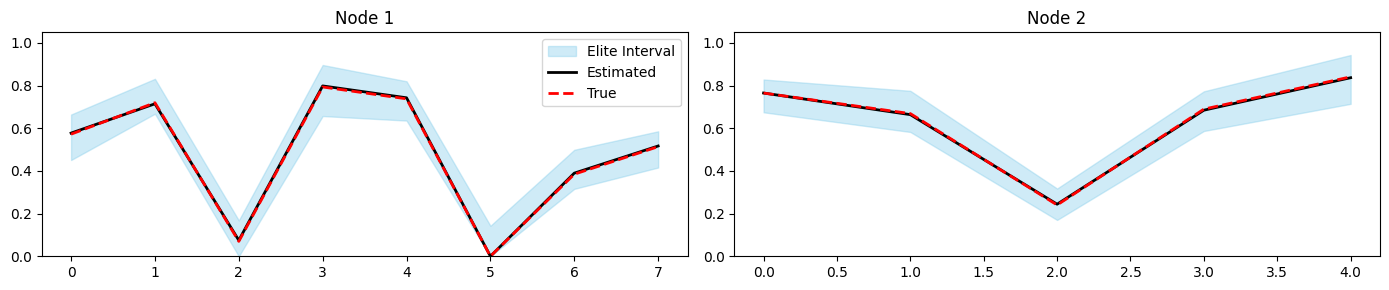

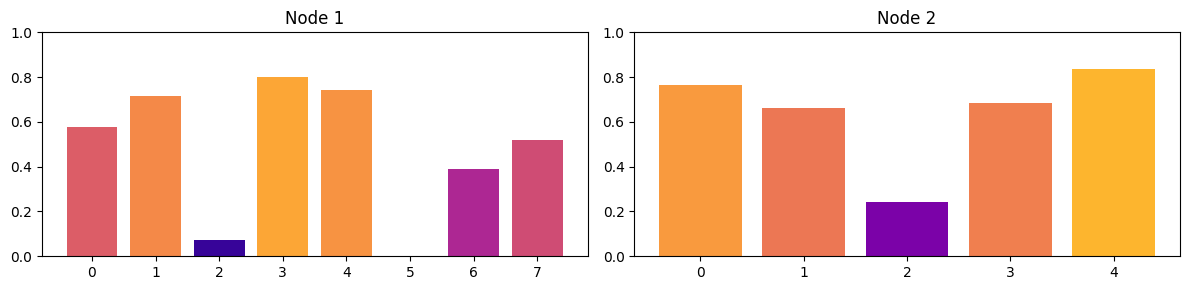

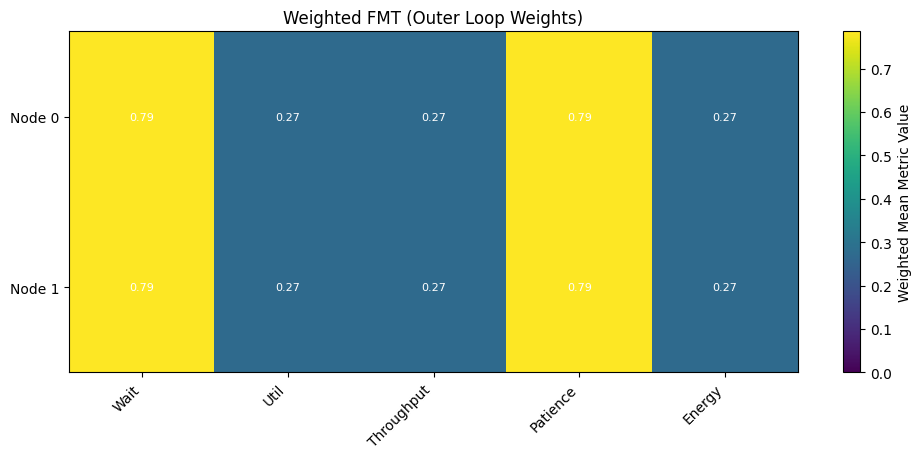

/tmp/ipykernel_11210/3102032862.py:588: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


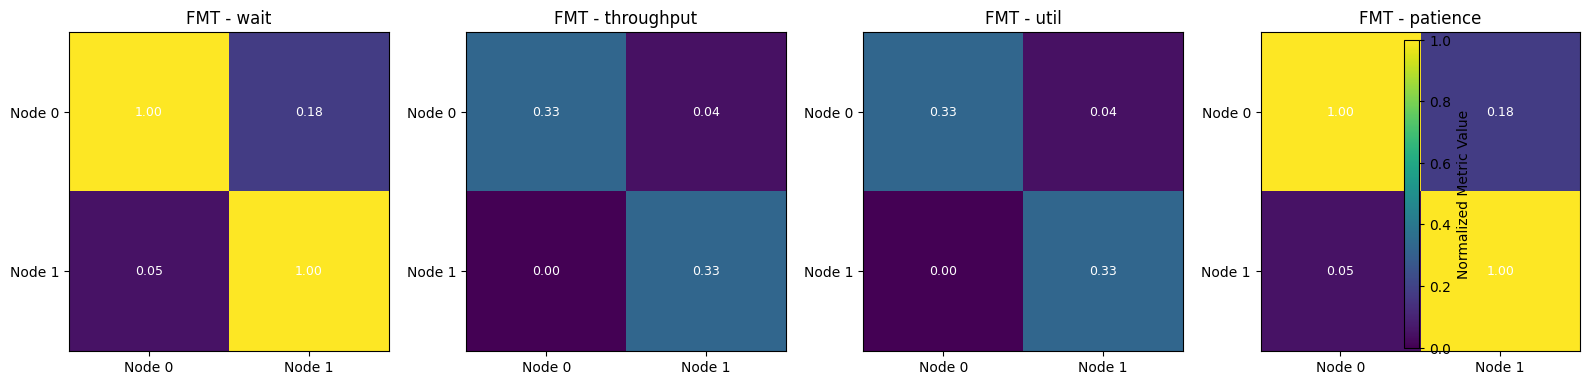

/tmp/ipykernel_11210/3102032862.py:712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


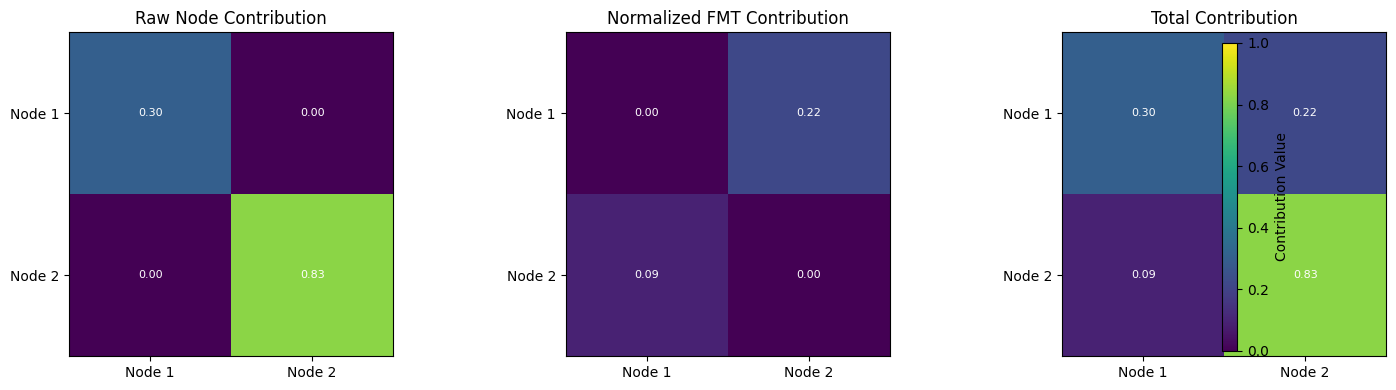

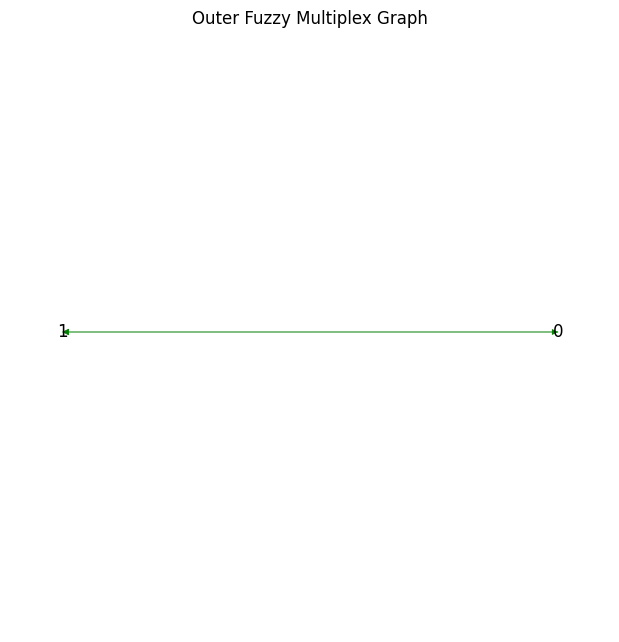

Node 0 -> Node 1: [0.637, 0.580, 0.512, 0.450, 0.542, 0.531, 0.542, 0.529]
Node 1 -> Node 0: [0.520, 0.413, 0.489, 0.452, 0.597, 0.518, 0.560, 0.558]
Tensor shape: (2, 2, 8) 
 [[[0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.63714075 0.58044608 0.51170377 0.45046054 0.54178578 0.53089442
   0.54241265 0.52862424]]

 [[0.52013939 0.41257381 0.4892012  0.45211437 0.5971836  0.51779476
   0.55994094 0.55846327]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]]


In [23]:


import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


# ---------------- CONFIG ----------------nsion

inner_archive_size = 80
inner_offspring = 40
outer_archive_size = 40
outer_offspring = 40
inner_iters_per_outer = 50
outer_generations = 10
outer_cost_limit = 10000
inner_learning = 0.1
gamma_interlayer = 1
top_k = 13
seed = np.random.seed()

new_DATA_MATRIX = np.random.rand(D_graph, DATA_MATRIX.shape[1])



class InterLayer:
    def __init__(self, D_graph, max_inner_dim, inter_dim=None, edge_threshold=0.02, gamma=1.0, seed=42):
        np.random.seed(seed)
        self.D_graph = D_graph
        self.edge_threshold = edge_threshold
        self.gamma = gamma
        self.inter_dim = inter_dim[0] if isinstance(inter_dim, list) else (inter_dim if inter_dim is not None else max_inner_dim[0] if isinstance(max_inner_dim, list) else max_inner_dim)
        self.max_input = 2 * (max_inner_dim[0] if isinstance(max_inner_dim, list) else max_inner_dim)
                    # Initialize weights proportional to synthetic correlation between nodes
        self.weights = {}
        self.bias = {}
        for i in range(D_graph):
            for j in range(D_graph):
                if i != j:
                    # small random + slight bias towards correlation
                    w_init = np.random.uniform(-0.1, 0.1, (self.inter_dim, self.max_input))
                    self.weights[(i,j)] = w_init
                    self.bias[(i,j)] = np.zeros(self.inter_dim)

    def compute_edge_activation(self, i, j, nested_reps):
        concat = np.concatenate([nested_reps[i], nested_reps[j]])
        concat = np.pad(concat, (0, max(0, self.max_input - len(concat))))[:self.max_input]

        # Normalize input to improve correlation
        concat = (concat - np.mean(concat)) / (np.std(concat) + 1e-12)

        # Compute activation
        v = self.weights[(i,j)].dot(concat) + self.bias[(i,j)]

        # Scale by correlation strength with input signals
        input_strength = np.clip(np.mean(np.abs(concat)), 0, 1)
        v = v * input_strength

        return 1 / (1 + np.exp(-v))

    def build_activations(self, Gmat, nested_reps):
        acts = {}
        for i in range(self.D_graph):
            for j in range(self.D_graph):
                if i == j:
                    continue
                if abs(Gmat[i,j]) > self.edge_threshold:
                    acts[(i,j)] = self.compute_edge_activation(i, j, nested_reps)
        return acts

    @staticmethod
    def pairwise_squared_corr(acts):
        if len(acts) < 2:
            return 0.0
        A = np.stack(list(acts.values()))
        A_centered = A - A.mean(axis=1, keepdims=True)
        stds = np.sqrt(np.sum(A_centered**2, axis=1) / (A.shape[1]-1) + 1e-12)
        cov = A_centered @ A_centered.T / (A.shape[1]-1)
        corr = cov / (np.outer(stds, stds) + 1e-12)
        np.fill_diagonal(corr, 0)
        return float((corr**2).sum())

    def mi_for_graph(self, Gmat, nested_reps):
        acts = self.build_activations(Gmat, nested_reps)
        if not acts:
            return 0.0
        return self.gamma * self.pairwise_squared_corr(acts)

    def correlate_shrink_interlayer(self, fmt_bounds=None, interaction_tensor=None, metrics_keys=None, verbose=True):
        """
        Compute Pearson correlation per node & metric between:
            - shrink factor (adaptive FMT)
            - mean outgoing inter-layer activations
        Returns: {node_idx: {metric: {'r':..., 'p':...}}}
        """
        from scipy.stats import pearsonr

        if metrics_keys is None:
            metrics_keys =self.MK

        D = self.D_graph

        # 1. Compute FMT bounds if not given
        if fmt_bounds is None:
            fmt_bounds = self.compute_fmt_with_bounds_adaptive(top_k=top_k)

        # 2. Get inter-layer activations if not provided
        if interaction_tensor is None:
            interaction_tensor = self.print_interactions(return_tensor=True, verbose=False)

        inter_mean = interaction_tensor.mean(axis=2)  # (D,D)
        shrink_factors = self.compute_fmt_shrink_factor(fmt_bounds, metrics_keys)  # (D, num_metrics)

        correlations = {}

        for i in range(D):
            correlations[i] = {}
            for k, key in enumerate(metrics_keys):
                # FMT shrink for node i (broadcasted across outgoing edges)
                shrink_vec = shrink_factors[i, k] * np.ones(D)
                # Outgoing inter-layer activations from node i
                inter_vec = inter_mean[i, :]
                # Remove self-loop
                mask = np.arange(D) != i
                shrink_vec = shrink_vec[mask]
                inter_vec = inter_vec[mask]

                # Compute Pearson correlation
                if np.std(inter_vec) > 1e-8:  # valid correlation
                    r, p = pearsonr(shrink_vec, inter_vec)
                else:
                    r, p = 0.0, 1.0  # no variability

                correlations[i][key] = {'r': r, 'p': p}
                if verbose:
                    print(f"Node {i} | {key} shrink vs inter-layer: r={r:.3f}, p={p:.3e}")

        return correlations



# ---------------- UNIFIED ACOR MULTIPLEX ----------------
class Fuzzy_Hierarchical_Multiplex:
    def __init__(self, candidate_dims, D_graph, inner_archive_size, inner_offspring,
                 outer_archive_size, outer_offspring, synthetic_targets, inner_learning,
                 gamma_interlayer=1.0, causal_flag=True,metrics=METRIC_KEYS):
        self.candidate_dims = candidate_dims
        self.D_graph = D_graph
        self.inner_archive_size = inner_archive_size
        self.inner_offspring = inner_offspring
        self.outer_archive_size = outer_archive_size
        self.outer_offspring = outer_offspring
        self.synthetic_targets = synthetic_targets
        self.inner_learning = inner_learning
        self.causal_flag = causal_flag
        self.best_dim_per_node = [len(t)-1 for t in synthetic_targets]  # last element as best dim

        self.MK = metrics
        self.MKI = metrics+['score']
        self.nested_reps = [np.zeros(c[0]) for c in candidate_dims]
      #  self.best_dim_per_node = [candidate_dims[0] for _ in range(D_graph)]
        self.inter_layer = InterLayer(D_graph, max_inner_dim=max(candidate_dims), gamma=gamma_interlayer)
        self.chosen_Gmat = np.random.uniform(-0.5,0.5,(D_graph,D_graph))
        np.fill_diagonal(self.chosen_Gmat,0)
        self.l2_before, self.l2_after = [], []

    # ---------- INNER LOOP (FCM) ----------
    def run_inner(self, node_idx, target, D_fcm,
              steps=100, lr_x=0.001, lr_y=0.001, lr_W=0.001,
              decorrelate_metrics=True):

        # --- Initialize activations ---
        x = target.copy()#np.random.uniform(0, 1, D_fcm)

        y = np.random.uniform(-0.6, 0.6, (D_fcm))

        # Pad target for L2 computation
        target_padded = np.pad(target, (0, len(self.nested_reps[node_idx]) - len(target)),
                            mode='constant', constant_values=0.5)
        self.l2_before.append(np.linalg.norm(self.nested_reps[node_idx] - target_padded))

        # --- FCM updates ---
        W = np.random.uniform(-0.6, 0.6, (D_fcm, D_fcm))

        np.fill_diagonal(W, 0)

        for _ in range(steps):
            z = y.dot(W) + x
            Theta_grad_z = z - target
            Theta_grad_x = Theta_grad_z
            Theta_grad_y = Theta_grad_z.dot(W.T)
            Theta_grad_W = np.outer(y, Theta_grad_z)
         #   Theta_grad_z = 2 * z - target_padded
          #  Theta_grad_x = W.T @ Theta_grad_z + (y + 1)

           # Theta_grad_y = x + 1
            #Theta_grad_W = np.outer(Theta_grad_z, x)

            x -= lr_x * np.clip(Theta_grad_x, -0.05, 0.05)
            y -= lr_y * np.clip(Theta_grad_y, -0.05, 0.05)
            W -= lr_W * np.clip(Theta_grad_W, -0.01, 0.01)

            x = np.clip(x, 0, 1)
            y = np.clip(y, 0, 1)
            np.fill_diagonal(W, 0)
            W = np.clip(W, -1, 1)

        # Pad FCM output to max dim for nested_reps
        x_padded = np.pad(x, (0, len(self.nested_reps[node_idx]) - len(x)),
                        mode='constant', constant_values=0.5)
        self.nested_reps[node_idx] = x_padded
        self.l2_after.append(np.linalg.norm(x_padded - target_padded))

        # --- Compute metrics ONCE ---
        metrics_evaluator = MetricsEvaluator(DATA_MATRIX)
        metrics = metrics_evaluator.compute_node_metrics(node_idx, y=x)

        # --- Compute MI score for inter-layer ---
        mi_score = self.inter_layer.mi_for_graph(self.chosen_Gmat, self.nested_reps)

        return x, y, W, mi_score, metrics


    def run_outer(self):
        """
        Full outer loop optimization with:
        1. Node contribution weights
        2. Correlation penalty weights
        3. Meta-optimization on overall fitness
        Uses normalized Fuzzy Metric Tensor for final calculations.
        Stores all weights and weighted FMT as attributes.
        """
        import numpy as np
        from scipy.optimize import minimize

        node_metrics_list = self.capped_node_metrics
        raw_scores = np.array([m['score'] for m in node_metrics_list])
        D = self.D_graph

        # --- Compute Fuzzy Metric Tensor and normalize per node ---
        fuzzy_tensor = self.compute_fuzzy_metric_tensor(normalize=True)  # normalized now
        gamma = self.inter_layer.gamma

        # --- Compute per-node fuzzy sums ---
        fmt_node_sums = np.array([
            fuzzy_tensor[i,:,:].sum() - fuzzy_tensor[i,i,:].sum()
            for i in range(D)
        ])

        # --- Prepare interaction tensor ---
        interaction_tensor = self.print_interactions(return_tensor=True, verbose=False)
        fmt_mean = fuzzy_tensor.mean(axis=2)
        inter_mean = interaction_tensor.mean(axis=2)

        lambda_reg = 0.05

        # ---------- 1. Node contribution optimization ----------
        def objective_contrib(weights):
            node_contrib = weights * (raw_scores + gamma * fmt_node_sums)
            reg_penalty = lambda_reg * np.sum((weights - 1.0/D)**2)
            return - (node_contrib.sum() - reg_penalty)

        bounds = [(0.4, 0.7)] * D
        cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
        x0 = np.ones(D)/D

        result_contrib = minimize(objective_contrib, x0=x0, bounds=bounds, constraints=cons, method='SLSQP')
        best_w_contrib = result_contrib.x / result_contrib.x.sum()

        # ---------- 2. Correlation penalty optimization ----------
        def objective_corr(weights):
            corr_penalty = 0.0
            for i in range(D):
                fmt_vec = weights[i] * fmt_mean[i,:]
                inter_vec = weights[i] * inter_mean[i,:]
                if np.std(fmt_vec) > 1e-8 and np.std(inter_vec) > 1e-8:
                    corr_penalty += abs(np.corrcoef(fmt_vec, inter_vec)[0,1])**2
            corr_penalty /= D
            reg_penalty = lambda_reg * np.sum((weights - 1.0/D)**2)
            return corr_penalty + reg_penalty

        result_corr = minimize(objective_corr, x0=x0, bounds=bounds, constraints=cons, method='SLSQP')
        best_w_corr = result_corr.x / result_corr.x.sum()

        # ---------- 3. Meta-optimization on combined score ----------
        def fitness_meta(alpha):
            alpha = alpha / alpha.sum()  # normalize meta-weights
            node_contrib = alpha * (raw_scores + gamma * fmt_node_sums) * best_w_contrib
            corr_penalty = 0.0
            for i in range(D):
                fmt_vec = alpha[i] * fmt_mean[i,:] * best_w_corr[i]
                inter_vec = alpha[i] * inter_mean[i,:] * best_w_corr[i]
                if np.std(fmt_vec) > 1e-8 and np.std(inter_vec) > 1e-8:
                    corr_penalty += abs(np.corrcoef(fmt_vec, inter_vec)[0,1])**2
            corr_penalty /= D
            return -node_contrib.sum() + corr_penalty  # minimize fitness

        x0_meta = np.ones(D)/D
        bounds_meta = [(0.4, 0.7)] * D
        cons_meta = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}

        result_meta = minimize(fitness_meta, x0=x0_meta, bounds=bounds_meta, constraints=cons_meta, method='SLSQP')
        best_alpha = result_meta.x / result_meta.x.sum()

        # --- Final node contributions ---
        node_contributions = best_alpha * (raw_scores + gamma * fmt_node_sums) * best_w_contrib

        # --- Final correlation penalty ---
        corr_penalty = 0.0
        for i in range(D):
            fmt_vec = best_alpha[i] * fmt_mean[i,:] * best_w_corr[i]
            inter_vec = best_alpha[i] * inter_mean[i,:] * best_w_corr[i]
            if np.std(fmt_vec) > 1e-8 and np.std(inter_vec) > 1e-8:
                corr_penalty += abs(np.corrcoef(fmt_vec, inter_vec)[0,1])**2
        corr_penalty /= D

        combined_score = node_contributions.sum() - corr_penalty

        # --- Weighted FMT ---
        weighted_fmt = fuzzy_tensor.copy()
        for i in range(D):
            weighted_fmt[i,:,:] *= best_alpha[i] * best_w_contrib[i]

        # --- Save attributes ---
        self.node_score_contributions = node_contributions
        self.correlation_penalty = corr_penalty
        self.best_w_contrib = best_w_contrib
        self.best_w_corr = best_w_corr
        self.best_alpha = best_alpha
        self.weighted_fmt = weighted_fmt

        return node_metrics_list, combined_score, node_contributions





    def run(self, outer_generations=outer_generations):
        best_score = -np.inf

        for gen in range(outer_generations):
            node_metrics_list = []

            for node_idx in range(self.D_graph):
                full_target = self.synthetic_targets[node_idx]['target']
                D_fcm = self.candidate_dims[node_idx][0]
                target = full_target[:D_fcm]

                _, _, _, _, metrics = self.run_inner(node_idx, target, D_fcm)
                node_metrics_list.append(metrics)

            # Outer loop
            self.capped_node_metrics = node_metrics_list
            _, capped_score, node_contributions = self.run_outer()

            # --- Only print if this generation improves the best score ---
            if capped_score > best_score:
                best_score = capped_score

                print(f"\n--- Generation {gen} Metrics (NEW BEST) ---")
                for i, m in enumerate(node_metrics_list):
                    print(f"Node {i} | " + " | ".join([f"{k}: {v:.2f}" for k, v in m.items()]))

                print(f"\n--- Generation {gen} Node Contributions (NEW BEST) ---")
                for i, c in enumerate(node_contributions):
                    print(f"Node {i}: Contribution = {c:.4f}")

                print(f"Outer Score (capped): {capped_score:.3f} <-- NEW BEST")

        # --- Return only the best outer score ---
        return best_score


    # ---------- VISUALIZATIONS ----------
    # ---------- VISUALIZATIONS ----------
    def plot_pointwise_minmax_elite(self, top_k=21):
        plt.figure(figsize=(14,3))
        for i in range(self.D_graph):
            # Node's actual dimension
            dim_i = self.candidate_dims[i][0]  # ✅ integer
            base = self.nested_reps[i][:dim_i]  # slice to candidate dim
            reps = np.clip(base + np.random.normal(0,0.05,(top_k,len(base))),0,1)
            y_min, y_max = reps.min(axis=0), reps.max(axis=0)
            y_sel = base

            # True target for this node, sliced to candidate dim
            y_true = self.synthetic_targets[i]['target'][:len(y_sel)]
            if len(y_true) < len(y_sel):
                y_true = np.pad(y_true, (0, len(y_sel)-len(y_true)), "constant")
            else:
                y_true = y_true[:len(y_sel)]

            plt.subplot(1,self.D_graph,i+1)
            plt.fill_between(range(len(y_min)),y_min,y_max,color='skyblue',alpha=0.4,label='Elite Interval')
            plt.plot(y_sel,'k-',lw=2,label='Estimated')
            plt.plot(y_true,'r--',lw=2,label='True')
            plt.ylim(0,1.05)
            plt.title(f"Node {i+1}")
            if i==0: plt.legend()
        plt.tight_layout()
        plt.show()


    def plot_nested_activations(self):
        plt.figure(figsize=(12,3))
        for i,rep in enumerate(self.nested_reps):
            dim_i = self.candidate_dims[i][0]
            rep_i = rep[:dim_i]  # slice to candidate dim
            plt.subplot(1,self.D_graph,i+1)
            plt.bar(range(len(rep_i)), rep_i, color=plt.cm.plasma(rep_i))
            plt.ylim(0,1)
            plt.title(f"Node {i+1}")
        plt.tight_layout()
        plt.show()


    def plot_outer_fuzzy_graph(self):
        G = nx.DiGraph()
        for i in range(self.D_graph): G.add_node(i)
        for i in range(self.D_graph):
            for j in range(self.D_graph):
                if i!=j and abs(self.chosen_Gmat[i,j])>0.02:
                    G.add_edge(i,j,weight=self.chosen_Gmat[i,j])
        node_sizes = [self.best_dim_per_node[i]*200 for i in range(self.D_graph)]
        edge_colors = ['green' if d['weight']>0 else 'red' for _,_,d in G.edges(data=True)]
        edge_widths = [abs(d['weight'])*3 for _,_,d in G.edges(data=True)]
        pos = nx.circular_layout(G)
        plt.figure(figsize=(6,6))
        nx.draw(G,pos,node_size=node_sizes,node_color='skyblue',
                edge_color=edge_colors,width=edge_widths,arrows=True,with_labels=True)
        plt.title("Outer Fuzzy Multiplex Graph")
        plt.show()
# ---------------- INTERACTIONS INSPECTOR ----------------

    def print_interactions(self, return_tensor=True, verbose=True):
            D_graph = self.D_graph
            inter_dim = self.inter_layer.inter_dim
            inter_tensor = np.zeros((D_graph, D_graph, inter_dim))

            acts = self.inter_layer.build_activations(self.chosen_Gmat, self.nested_reps)
            if not acts:
                if verbose:
                    print("No active edges above threshold.")
                return inter_tensor if return_tensor else None

            for (i, j), vec in acts.items():
                inter_tensor[i, j, :] = vec
                if verbose:
                    act_str = ", ".join([f"{v:.3f}" for v in vec])
                    print(f"Node {i} -> Node {j}: [{act_str}]")
            return inter_tensor if return_tensor else None

        # Move these outside of print_interactions (class-level)
    def print_l2_summary(self):
            print("\nL2 Distances to Target per Node:")
            for idx, (before, after) in enumerate(zip(self.l2_before, self.l2_after)):
                print(f"Node {idx}: Before={before:.4f}, After={after:.4f}")

    def compute_fuzzy_metric_tensor(self, normalize=True, verbose=False):
            """
            Computes a Fuzzy Metric Tensor (D_graph x D_graph x num_metrics)
            using current nested reps and node metrics.
            Each slice [i,j,:] represents metrics of node j (optionally weighted by Gmat[i,j])
            """
            metrics_keys =self.MK
            D = self.D_graph
            num_metrics = len(metrics_keys)
            tensor = np.zeros((D, D, num_metrics))

            metrics_evaluator = MetricsEvaluator(DATA_MATRIX)

            node_metrics = []
            for i, rep in enumerate(self.nested_reps):
                metrics = metrics_evaluator.compute_node_metrics(i, y=rep)
                node_metrics.append(np.array([metrics[k] for k in metrics_keys]))
            node_metrics = np.array(node_metrics)  # (D, num_metrics)

            for i in range(D):
                for j in range(D):
                    if i==j:
                        tensor[i,j,:] = node_metrics[j]
                    else:
                        weight = np.clip(abs(self.chosen_Gmat[i,j]), 0, 1)
                        tensor[i,j,:] = weight * node_metrics[j]

            if normalize:
                tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min() + 1e-12)

            if verbose:
                print("Fuzzy Metric Tensor shape:", tensor.shape)

            return tensor



    def compute_fmt_shrink_factor(self, fmt_bounds, metrics_keys=None):
        """
        Returns shrink factor per node and metric.
        shrink_factor = 1 - (current_interval / original_interval)
        """
        if metrics_keys is None:
            metrics_keys = self.MK

        D = self.D_graph
        num_metrics = len(metrics_keys)
        shrink_factors = np.zeros((D, num_metrics))

        for i in range(D):
            for k in range(num_metrics):
                lower, upper = fmt_bounds[i, i, k, 0], fmt_bounds[i, i, k, 1]  # self-node interval
                interval_width = upper - lower + 1e-12  # normalized [0,1]
                shrink_factors[i, k] = 1 - interval_width  # more shrink = higher value

        return shrink_factors

    def compute_fmt_with_bounds_adaptive(self, top_k=21, max_shrink=0.5, metrics_keys=None):
        """
        Computes FMT bounds using pointwise min/max across elite solutions,
        and applies dynamic adaptive shrinking where variability is low.
        Returns tensor shape (D,D,num_metrics,2) [lower, upper].
        """
        if metrics_keys is None:
            metrics_keys =self.MK

        D = self.D_graph
        num_metrics = len(metrics_keys)
        tensor_bounds = np.zeros((D, D, num_metrics, 2))
        metrics_evaluator = MetricsEvaluator(DATA_MATRIX)

        variability = np.zeros((D, num_metrics))

        # Step 1: compute bounds from perturbations
        for i in range(D):
            base = self.nested_reps[i]
            reps = np.clip(base + np.random.normal(0, 0.05, (top_k, len(base))), 0, 1)
            metrics_matrix = np.zeros((top_k, num_metrics))
            for idx, rep in enumerate(reps):
                m = metrics_evaluator.compute_node_metrics(i, y=rep)
                metrics_matrix[idx, :] = [m[k] for k in metrics_keys]

            lower_i = metrics_matrix.min(axis=0)
            upper_i = metrics_matrix.max(axis=0)
            tensor_bounds[i, :, :, 0] = lower_i[np.newaxis, :]  # broadcast to all j
            tensor_bounds[i, :, :, 1] = upper_i[np.newaxis, :]
            variability[i, :] = metrics_matrix.std(axis=0)

        # Step 2: adaptive shrinking
        for i in range(D):
            for j in range(D):
                for k in range(num_metrics):
                    lower, upper = tensor_bounds[i,j,k,0], tensor_bounds[i,j,k,1]
                    mean = (lower + upper)/2
                    var_norm = min(1.0, variability[i,k]/(upper-lower + 1e-12))
                    shrink_factor = max_shrink * (1 - var_norm)
                    tensor_bounds[i,j,k,0] = mean - shrink_factor*(mean - lower)
                    tensor_bounds[i,j,k,1] = mean + shrink_factor*(upper - mean)

        return tensor_bounds



    def plot_fuzzy_metric_tensor_heatmaps(self, fuzzy_tensor=None, metrics_keys=['wait','throughput','util','patience']):
        """
        Plot a heatmap panel for each metric in the FMT.
        Rows: source node i
        Columns: target node j
        """
        if fuzzy_tensor is None:
            fuzzy_tensor = self.compute_fuzzy_metric_tensor(normalize=True)

        D = self.D_graph
        num_metrics = len(metrics_keys)

        fig, axes = plt.subplots(1, num_metrics, figsize=(4*num_metrics,4))
        if num_metrics == 1: axes = [axes]

        for k, key in enumerate(metrics_keys):
            data = fuzzy_tensor[:,:,k]
            im = axes[k].imshow(data, cmap='viridis', vmin=0, vmax=1)
            for i in range(D):
                for j in range(D):
                    axes[k].text(j,i,f"{data[i,j]:.2f}",ha='center',va='center',color='white',fontsize=9)
            axes[k].set_xticks(range(D))
            axes[k].set_yticks(range(D))
            axes[k].set_xticklabels([f'Node {j}' for j in range(D)])
            axes[k].set_yticklabels([f'Node {i}' for i in range(D)])
            axes[k].set_title(f'FMT - {key}')

        fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, label='Normalized Metric Value')
        plt.tight_layout()
        plt.show()

    def compute_fmt_with_elite_bounds(self, top_k=21):
        """
        Computes FMT bounds using pointwise min/max across elite solutions.
        Returns tensor shape (D,D,num_metrics,2) [lower, upper].
        """
        metrics_keys = self.MK
        D = self.D_graph
        num_metrics = len(metrics_keys)
        tensor_bounds = np.zeros((D,D,num_metrics,2))

        metrics_evaluator = MetricsEvaluator(DATA_MATRIX)

        for i in range(D):
            # Generate top_k perturbations around current nested_rep (like in plot_pointwise_minmax_elite)
            base = self.nested_reps[i]
            reps = np.clip(base + np.random.normal(0,0.05,(top_k,len(base))),0,1)

            # Compute node metrics for each perturbed solution
            metrics_matrix = np.zeros((top_k, num_metrics))
            for idx, rep in enumerate(reps):
                m = metrics_evaluator.compute_node_metrics(i, y=rep)
                metrics_matrix[idx,:] = [m[k] for k in metrics_keys]

            # Compute pointwise min/max across elite solutions
            lower_i = metrics_matrix.min(axis=0)
            upper_i = metrics_matrix.max(axis=0)

            # Fill bounds tensor for all source nodes (i->j)
            for j in range(D):
                tensor_bounds[i,j,:,0] = lower_i
                tensor_bounds[i,j,:,1] = upper_i

        return tensor_bounds


    def plot_fmt_with_bounds(self, fmt_tensor_bounds):
        D = self.D_graph
        metrics_keys = self.MK

        # Extract lower/upper for each metric and compute mean
        mean_vals = (fmt_tensor_bounds[:, :, :, 0] + fmt_tensor_bounds[:, :, :, 1]) / 2  # (D,D,M_actual)
        M_actual = mean_vals.shape[2]

        # Apply outer-loop weights if available
        if hasattr(self, 'best_weights'):
            for i in range(D):
                mean_vals[i, :, :] *= self.best_weights[i]

        # Take any column (say j=0) for unique row values
        unique_mean = mean_vals[:, 0, :]  # shape (D, M_actual)

        # Plotting
        fig, ax = plt.subplots(figsize=(1.2*M_actual + 4, 0.35*D + 4))
        im = ax.imshow(unique_mean, cmap='viridis', aspect='auto', vmin=0, vmax=unique_mean.max())

        # Annotate heatmap with weighted mean values
        for i in range(D):
            for k in range(M_actual):
                ax.text(k, i, f"{unique_mean[i,k]:.2f}", ha='center', va='center', color='white', fontsize=8)

        # Label axes
        ax.set_xticks(range(M_actual))
        ax.set_xticklabels(metrics_keys[:M_actual], rotation=45, ha='right')
        ax.set_yticks(range(D))
        ax.set_yticklabels([f"Node {i}" for i in range(D)])

        ax.set_title("Weighted FMT (Outer Loop Weights)")
        fig.colorbar(im, ax=ax, label='Weighted Mean Metric Value')
        plt.tight_layout()
        plt.show()

    def plot_node_score_contribution(self, metrics_keys=METRIC_KEYS):
        """
        Plot per-node total score contribution:
            - 3 panels: Raw, FMT (interaction), Total
            - Diagonal represents raw contributions
            - FMT scaled by best_weights if available
            - Annotated cells
            - Normalized across metrics for consistent visualization
        """
        D = self.D_graph
        node_contributions = np.array(self.node_score_contributions)

        # --- FMT contribution ---
        if hasattr(self, 'weighted_fmt'):
            fuzzy_tensor = np.array(self.weighted_fmt)
        else:
            fuzzy_tensor = self.compute_fuzzy_metric_tensor(normalize=True)

        # Normalize across entire tensor for plotting
        fuzzy_tensor_norm = (fuzzy_tensor - fuzzy_tensor.min()) / (fuzzy_tensor.max() - fuzzy_tensor.min() + 1e-12)
        fmt_matrix = fuzzy_tensor_norm.sum(axis=2)  # sum over metrics
        np.fill_diagonal(fmt_matrix, 0)

        # --- Raw matrix on diagonal ---
        raw_matrix = np.zeros((D,D))
        np.fill_diagonal(raw_matrix, node_contributions)

        # --- Total contribution ---
        total_matrix = raw_matrix + fmt_matrix

        # --- Global min/max for color scale ---
        global_min, global_max = total_matrix.min(), total_matrix.max()

        # --- Plot ---
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        matrices = [raw_matrix, fmt_matrix, total_matrix]
        titles = ["Raw Node Contribution", "Normalized FMT Contribution", "Total Contribution"]

        for ax, mat, title in zip(axes, matrices, titles):
            im = ax.imshow(mat, cmap='viridis', vmin=0, vmax=1)  # normalized
            for i in range(D):
                for j in range(D):
                    ax.text(j, i, f"{mat[i,j]:.2f}", ha='center', va='center', color='white', fontsize=8)
            ax.set_title(title)
            ax.set_xticks(range(D))
            ax.set_xticklabels([f"Node {i+1}" for i in range(D)])
            ax.set_yticks(range(D))
            ax.set_yticklabels([f"Node {i+1}" for i in range(D)])

        fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, label='Contribution Value')
        plt.tight_layout()
        plt.show()

    def correlate_fmt_interactions_per_node(self, fmt_bounds=None, interaction_tensor=None, verbose=True):
        """
        Correlate the FMT bounds with inter-layer interactions per node and per metric.
        Returns a dict of shape: {node_idx: {metric: {'r':..., 'p':...}}}.
        """
        from scipy.stats import pearsonr
        import matplotlib.pyplot as plt

        metrics_keys = self.MK
        D = self.D_graph

        # Compute tensors if not provided
        if fmt_bounds is None:
            fmt_bounds = self.compute_fmt_with_elite_bounds(top_k=21)
        if interaction_tensor is None:
            interaction_tensor = self.print_interactions(return_tensor=True, verbose=False)

        # Reduce interaction tensor along inter_dim
        inter_mean = interaction_tensor.mean(axis=2)  # (D,D)

        node_correlations = {}

        for i in range(D):
            node_correlations[i] = {}
            for k, key in enumerate(metrics_keys):
                # FMT bounds for target node j from source i (mean of lower/upper)
                fmt_mean = fmt_bounds[i,:,k,:].mean(axis=1)  # shape (D,)
                # Interaction tensor for edges from node i to j
                inter_vec = inter_mean[i,:]  # shape (D,)
                # Pearson correlation
                corr, pval = pearsonr(fmt_mean, inter_vec)
                node_correlations[i][key] = {'r': corr, 'p': pval}

                if verbose:
                    print(f"Node {i} | {key}: r = {corr:.3f}, p = {pval:.3e}")
                    plt.figure(figsize=(4,3))
                    plt.scatter(fmt_mean, inter_vec, alpha=0.7, edgecolor='k', color='skyblue')
                    plt.xlabel(f"FMT {key} (Node {i} -> others)")
                    plt.ylabel(f"Interaction mean (Node {i} -> others)")
                    plt.title(f"Node {i} | {key} correlation: r={corr:.3f}")
                    plt.grid(True)
                    plt.show()

        return node_correlations

    def correlation_penalty(self, fmt_bounds=None, interaction_tensor=None):
        """
        Computes a penalty term that is high if per-node FMT metrics correlate with interactions.
        Returns total penalty to subtract from the outer score.
        """
        from scipy.stats import pearsonr

        D = self.D_graph
        metrics_keys = self.MK
        if fmt_bounds is None:
            fmt_bounds = self.compute_fmt_with_elite_bounds(top_k=top_k)
        if interaction_tensor is None:
            interaction_tensor = self.print_interactions(return_tensor=True, verbose=False)

        inter_mean = interaction_tensor.mean(axis=2)
        total_penalty = 0.0

        for i in range(D):
            for k in range(len(metrics_keys)):
                fmt_mean = fmt_bounds[i,:,k,:].mean(axis=1)
                inter_vec = inter_mean[i,:]
                if np.std(fmt_mean) > 1e-8 and np.std(inter_vec) > 1e-8:
                    corr, _ = pearsonr(fmt_mean, inter_vec)
                    total_penalty += abs(corr)  # penalize high correlation

        # normalize by number of nodes × metrics
        total_penalty /= (D * len(metrics_keys))**2
        return total_penalty


# ---------------- USAGE ----------------
if __name__ == "__main__":
    optimizer = Fuzzy_Hierarchical_Multiplex(
        candidate_dims, D_graph,
        inner_archive_size, inner_offspring,
        outer_archive_size, outer_offspring,
        synthetic_targets,
        inner_learning, gamma_interlayer=-1,
        causal_flag=False
    )
    metrics_list = optimizer.run()
    optimizer.plot_pointwise_minmax_elite()
    optimizer.plot_nested_activations()
    # Compute FMT with elite bounds
    fmt_elite_bounds = optimizer.compute_fmt_with_elite_bounds(top_k=top_k+10)

# Plot as heatmaps
    optimizer.plot_fmt_with_bounds(fmt_elite_bounds)

    # Compute fuzzy multiplex tensor
    fmt_tensor = optimizer.compute_fuzzy_metric_tensor(normalize=True)
    optimizer.plot_fuzzy_metric_tensor_heatmaps(fmt_tensor)

    # Compute FMT with bounds (minimax elite intervals)
    optimizer.plot_node_score_contribution()
    optimizer.plot_outer_fuzzy_graph()
  #  optimizer.print_interactions()
    tensor = optimizer.print_interactions()

    print("Tensor shape:", tensor.shape,'\n',tensor)
    # Compute tensors first
    fmt_elite_bounds = optimizer.compute_fmt_with_elite_bounds(top_k=top_k)
    interaction_tensor = optimizer.print_interactions(return_tensor=True, verbose=False)


    #interaction_tensor = optimizer.print_interactions(return_tensor=True, verbose=False)

    # Get per-node, per-metric correlations
    #node_metric_corrs = optimizer.correlate_fmt_interactions_per_node(
     #   fmt_bounds=fmt_elite_bounds,
      #  interaction_tensor=interaction_tensor
   # )

In [24]:

import numpy as np

class GDFCMPredictorForward:
    """
    Forward predictor for GDFCM.
    Can handle new input data (DATA_MATRIX) and compute:
        - Node activations
        - Node metrics
        - Inter-layer MI scores
        - Total contributions and outer score
    """
    def __init__(self, trained_gdfcm: Fuzzy_Hierarchical_Multiplex):
        self.gdfcm = trained_gdfcm
        self.D_graph = trained_gdfcm.D_graph
        self.nested_reps = trained_gdfcm.nested_reps
        self.chosen_Gmat = trained_gdfcm.chosen_Gmat
        self.inter_layer = trained_gdfcm.inter_layer

    def predict_node(self, node_idx, data_row):
        """
        Predict metrics and activations for a single node given a new data row.
        """
        # Use stored nested_rep as starting point
        x = self.nested_reps[node_idx].copy()
        # Optional: you could combine with data_row to modify x
        # For now, we just compute metrics using data_row as the input
        metrics_evaluator = MetricsEvaluator(np.array([data_row]))
        metrics = metrics_evaluator.compute_node_metrics(0, y=x)

        # Inter-layer MI
        mi_score = self.inter_layer.mi_for_graph(self.chosen_Gmat, self.nested_reps)

        return {'activations': x, 'metrics': metrics, 'mi_score': mi_score}

    def predict_all_nodes(self, new_data_matrix):
        """
        Predict metrics and activations for all nodes using new data.
        new_data_matrix: shape (D_graph, num_features)
        """
        results = []
        for node_idx in range(self.D_graph):
            data_row = new_data_matrix[node_idx % len(new_data_matrix)]
            node_result = self.predict_node(node_idx, data_row)
            results.append(node_result)
        return results

    def predict_scores(self):
        """
        Compute per-node contributions and total outer score.
        """
        _, total_score, node_contributions = self.gdfcm.run_outer()
        return {'node_contributions': node_contributions, 'total_score': total_score}
# Suppose optimizer is your trained GDFCM
predictor = GDFCMPredictorForward(optimizer)

# New data: same number of nodes, each with same num_features

# Predict all nodes
predictions = predictor.predict_all_nodes(new_DATA_MATRIX)

for idx, node_pred in enumerate(predictions):
    print(f"Node {idx} Metrics:", node_pred['metrics'])
    print(f"Node {idx} Activations:", node_pred['activations'])
    print(f"Node {idx} MI Score:", node_pred['mi_score'])

# Optional: compute total contributions
score_info = predictor.predict_scores()
print("Node Contributions:", score_info['node_contributions'])
print("Total Score:", score_info['total_score'])

class GDFCMPredictorAdaptive:
    """
    Adaptive forward predictor for GDFCM.
    - Accepts new data per node.
    - Updates activations slightly using a mini inner-loop.
    - Computes metrics, inter-layer MI, and outer score contributions.
    """
    def __init__(self, trained_gdfcm: Fuzzy_Hierarchical_Multiplex, lr_x=0.01, lr_steps=10):
        self.gdfcm = trained_gdfcm
        self.D_graph = trained_gdfcm.D_graph
        self.nested_reps = [rep.copy() for rep in trained_gdfcm.nested_reps]
        self.chosen_Gmat = trained_gdfcm.chosen_Gmat
        self.inter_layer = trained_gdfcm.inter_layer
        self.lr_x = lr_x
        self.lr_steps = lr_steps

    def adapt_node(self, node_idx, data_row):
        """
        Mini inner-loop: slightly update activations based on new data row.
        Handles shape mismatch by projecting new data to node activation dim.
        """
        x = self.nested_reps[node_idx].copy()
        dim = len(x)

        # Simple linear projection of new data to activation space
        if len(data_row) != dim:
            # Use mean pooling to reduce or slice if too large
            if len(data_row) > dim:
                target = data_row[:dim]
            else:
                # Pad with 0.5
                target = np.pad(data_row, (0, dim - len(data_row)), 'constant', constant_values=0.5)
        else:
            target = data_row

        target = np.clip(target, 0, 1)

        # Mini inner-loop update
        for _ in range(self.lr_steps):
            grad = x - target
            x -= self.lr_x * grad
            x = np.clip(x, 0, 1)

        self.nested_reps[node_idx] = x

        # Compute metrics
        metrics_evaluator = MetricsEvaluator(np.array([data_row]))
        metrics = metrics_evaluator.compute_node_metrics(0, y=x)

        # Inter-layer MI
        mi_score = self.inter_layer.mi_for_graph(self.chosen_Gmat, self.nested_reps)

        return {'activations': x, 'metrics': metrics, 'mi_score': mi_score}


    def adapt_all_nodes(self, new_data_matrix):
        """
        Update activations for all nodes given new data matrix.
        """
        results = []
        for node_idx in range(self.D_graph):
            data_row = new_data_matrix[node_idx % len(new_data_matrix)]
            node_result = self.adapt_node(node_idx, data_row)
            results.append(node_result)
        return results

    def compute_outer_score(self):
        """
        Compute node contributions and total outer score using current nested_reps.
        """
        _, total_score, node_contributions = self.gdfcm.run_outer()
        return {'node_contributions': node_contributions, 'total_score': total_score}
# Initialize adaptive predictor
adaptive_predictor = GDFCMPredictorAdaptive(optimizer, lr_x=0.02, lr_steps=15)

# New data

# Adapt activations to new data
predictions = adaptive_predictor.adapt_all_nodes(new_DATA_MATRIX)

for idx, node_pred in enumerate(predictions):
    print(f"Node {idx} Metrics:", node_pred['metrics'])
    print(f"Node {idx} Activations:", node_pred['activations'])
    print(f"Node {idx} MI Score:", node_pred['mi_score'])

# Compute outer node contributions after adaptation
score_info = adaptive_predictor.compute_outer_score()
print("Node Contributions:", score_info['node_contributions'])
print("Total Score:", score_info['total_score'])
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error

pred_metrics = []
true_metrics = []
for idx, data_row in enumerate(new_DATA_MATRIX):
    pred = adaptive_predictor.adapt_node(idx, data_row)
    pred_metrics.append([pred['metrics'][k] for k in METRIC_KEYS])
    true_metrics.append([MetricsEvaluator(new_DATA_MATRIX).compute_node_metrics(idx)[k]
                         for k in METRIC_KEYS])

pred_metrics = np.array(pred_metrics)
true_metrics = np.array(true_metrics)


def evaluate_predictions(true_metrics, pred_metrics, metric_names=None):
    """
    Evaluate multi-metric predictions per node and overall.

    Args:
        true_metrics: np.array, shape (num_nodes, num_metrics)
        pred_metrics: np.array, same shape as true_metrics
        metric_names: list of metric names (optional)

    Returns:
        dict with evaluation metrics
    """
    true_metrics = np.array(true_metrics)

    pred_metrics = np.array(pred_metrics)

    if metric_names is None:
        metric_names = [f'Metric {i}' for i in range(true_metrics.shape[1])]

    num_nodes, num_metrics = true_metrics.shape

    results = {'per_metric': {}, 'overall': {}}

    # Per metric
    for i, name in enumerate(metric_names):
        t = true_metrics[:, i]
        p = pred_metrics[:, i]
        mae = mean_absolute_error(t, p)
        rmse = np.sqrt(mean_squared_error(t, p))
        r2 = r2_score(t, p)
        corr = np.corrcoef(t, p)[0,1]
        mape = np.mean(np.abs((t - p) / (t + 1e-12))) * 100
        results['per_metric'][name] = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'Pearson': corr,
            'MAPE (%)': mape
        }

    # Overall
    mae_overall = mean_absolute_error(true_metrics.flatten(), pred_metrics.flatten())
    rmse_overall = np.sqrt(mean_squared_error(true_metrics.flatten(), pred_metrics.flatten()))
    r2_overall = r2_score(true_metrics.flatten(), pred_metrics.flatten())

    # Cosine similarity (averaged over nodes)
    cos_sim = np.mean([cosine_similarity(t.reshape(1,-1), p.reshape(1,-1))[0,0]
                       for t,p in zip(true_metrics, pred_metrics)])

    results['overall'] = {
        'MAE': mae_overall,
        'RMSE': rmse_overall,
        'R2': r2_overall,
        'CosineSim': cos_sim
    }

    return results
# Suppose true_metrics and pred_metrics have shape (D_graph, 4)
metrics_eval = evaluate_predictions(true_metrics, pred_metrics, metric_names=METRIC_KEYS)

# Print per-metric evaluation
for metric, vals in metrics_eval['per_metric'].items():
    print(f"{metric}: {vals}")

# Print overall evaluation
print("\nOverall metrics:", metrics_eval['overall'])




Node 0 Metrics: {'Wait': 0.6498199544694272, 'Throughput': 0.5388877998006263, 'Util': 0.5388877998006263, 'Patience': 0.6498199544694272, 'Energy': 0.5388877998006263, 'score': 2.9163033083407335}
Node 0 Activations: [0.57750902 0.71492132 0.07481107 0.79875431 0.74311427 0.
 0.38979572 0.51707856]
Node 0 MI Score: -0.023300439887578222
Node 1 Metrics: {'Wait': 0.8528784648187633, 'Throughput': 0.17250000000000001, 'Util': 0.17250000000000001, 'Patience': 0.8528784648187633, 'Energy': 0.17250000000000001, 'score': 2.2232569296375266}
Node 1 Activations: [0.76539543 0.66405956 0.24414567 0.68495826 0.83722055]
Node 1 MI Score: -0.023300439887578222
Node Contributions: [0.30446109 0.82634259]
Total Score: 0.13080367701318196
Node 0 Metrics: {'Wait': 0.6498199544694272, 'Throughput': 0.5388877998006263, 'Util': 0.5388877998006263, 'Patience': 0.6498199544694272, 'Energy': 0.5388877998006263, 'score': 2.9163033083407335}
Node 0 Activations: [0.44117577 0.6580803  0.07744605 0.75040535 0.6

# Nested FCM

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ================================================================
#  SIMPLE FCM MODEL
# ================================================================
class SimpleFCM:
    def __init__(self, n_nodes, lr=0.05, max_iter=200, seed=0):
        self.n_nodes = n_nodes
        self.lr = lr
        self.max_iter = max_iter
        self.rng = np.random.default_rng(seed)
        self.W = self.rng.normal(0, 0.3, size=(n_nodes, n_nodes))
        np.fill_diagonal(self.W, 0.0)

    @staticmethod
    def activation(x):
        return 1.0 / (1.0 + np.exp(-x))

    def propagate(self, state):
        return self.activation(state @ self.W.T)

    def fit(self, X, Y):
        for _ in range(self.max_iter):
            idx = self.rng.integers(0, len(X))
            x = X[idx]
            y_true = Y[idx]
            y_pred = self.propagate(x)
            error = (y_true - y_pred)
            deltaW = self.lr * np.outer(error, x)
            np.fill_diagonal(deltaW, 0.0)
            self.W += deltaW

    def predict(self, X):
        return self.activation(X @ self.W.T)

# ================================================================
#  METRIC COMPUTATION: WAIT, THROUGHPUT, UTILIZATION, PATIENCE
# ================================================================
def compute_metrics(raw_data):
    """
    raw_data: (T, D, F) raw inputs for each node
    Returns: (T, D, 4) metrics [wait, throughput, utilization, patience]
    """
    T, D, F = raw_data.shape
    metrics = np.zeros((T, D, 4))  # wait, throughput, utilization, patience

    for t in range(T):
        for d in range(D):
            node_data = raw_data[t, d, :]

            # ---------------- CUSTOM FORMULAS ----------------
            # Replace these with your actual equations
            wait = node_data[0]            # e.g., avg queue length / arrival rate
            throughput = node_data[1]      # e.g., processed jobs / time interval
            utilization = node_data[2]     # e.g., busy time / total time
            patience = node_data[3]        # e.g., time until abandonment

            metrics[t, d, 0] = wait
            metrics[t, d, 1] = throughput
            metrics[t, d, 2] = utilization
            metrics[t, d, 3] = patience

    return metrics

# ================================================================
#  EVALUATION FUNCTION
# ================================================================
def evaluate_predictions(true_metrics, pred_metrics, metric_names=None):
    true_metrics = np.asarray(true_metrics)
    pred_metrics = np.asarray(pred_metrics)
    results = {'per_metric': {}, 'overall': {}}

    if true_metrics.ndim == 1:
        true_metrics = true_metrics[:, None]
    if pred_metrics.ndim == 1:
        pred_metrics = pred_metrics[:, None]

    num_nodes = true_metrics.shape[1]
    if metric_names is None:
        metric_names = [f'Node {i}' for i in range(num_nodes)]

    for i, name in enumerate(metric_names):
        t = true_metrics[:, i]
        p = pred_metrics[:, i]
        mae = mean_absolute_error(t, p)
        rmse = np.sqrt(mean_squared_error(t, p))
        r2 = r2_score(t, p)
        corr = np.corrcoef(t, p)[0, 1] if np.std(t) * np.std(p) > 0 else np.nan
        mape = np.mean(np.abs((t - p) / (t + 1e-12))) * 100
        results['per_metric'][name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Pearson': corr, 'MAPE (%)': mape}

    mae_overall = mean_absolute_error(true_metrics.flatten(), pred_metrics.flatten())
    rmse_overall = np.sqrt(mean_squared_error(true_metrics.flatten(), pred_metrics.flatten()))
    r2_overall = r2_score(true_metrics.flatten(), pred_metrics.flatten())
    cos_sim = np.mean([cosine_similarity(t.reshape(1, -1), p.reshape(1, -1))[0, 0]
                       for t, p in zip(true_metrics, pred_metrics)])
    results['overall'] = {'MAE': mae_overall, 'RMSE': rmse_overall, 'R2': r2_overall, 'CosineSim': cos_sim}

    return results

# ================================================================
#  FCM PIPELINE
# ================================================================
def run_fcm_pipeline(micro_data, test_size=0.2, lr=0.05, max_iter=500):
    T, D, M = micro_data.shape
    N = D * M
    # Flatten and normalize
    DATA_MATRIX = micro_data.reshape(T, N)
    DATA_MATRIX = (DATA_MATRIX - DATA_MATRIX.min(axis=0)) / (np.ptp(DATA_MATRIX, axis=0) + 1e-8)

    X_train, X_test = train_test_split(DATA_MATRIX, test_size=test_size, random_state=42)
    y_train, y_test = X_train.copy(), X_test.copy()

    fcm = SimpleFCM(n_nodes=N, lr=lr, max_iter=max_iter)
    fcm.fit(X_train, y_train)
    y_pred = fcm.predict(X_test)

    metric_names = [f"N{n}-M{m}" for n in range(D) for m in range(M)]
    metrics_eval = evaluate_predictions(y_test, y_pred, metric_names)
    return fcm, metrics_eval

# ================================================================
#  TWO-LAYER NESTED FCM PIPELINE
# ================================================================
def run_nested_fcm_pipeline(raw_data, test_size=0.2, lr=0.05, max_iter_layer1=500, max_iter_layer2=300):
    """
    raw_data: (T, D, F) raw inputs per node
    Layer 1: compute wait/throughput/util/patience and FCM
    Layer 2: inter-node FCM on Layer 1 predictions
    """
    # Compute Layer 1 metrics
    micro_data_metrics = compute_metrics(raw_data)

    # Layer 1 FCM
    fcm_layer1, eval_layer1 = run_fcm_pipeline(micro_data_metrics, test_size=test_size,
                                               lr=lr, max_iter=max_iter_layer1)

    # Get Layer 1 predictions
    T, D, M = micro_data_metrics.shape
    X_flat = micro_data_metrics.reshape(T, D * M)
    layer1_preds = fcm_layer1.predict(X_flat)
    layer1_preds_norm = (layer1_preds - layer1_preds.min(axis=0)) / (np.ptp(layer1_preds, axis=0) + 1e-8)
    layer1_preds_reshaped = layer1_preds_norm.reshape(T, D, M)

    # Layer 2 FCM on flattened Layer 1 outputs
    fcm_layer2, eval_layer2 = run_fcm_pipeline(layer1_preds_reshaped, test_size=test_size,
                                               lr=lr, max_iter=max_iter_layer2)

    return {
        'fcm_layer1': fcm_layer1,
        'eval_layer1': eval_layer1,
        'fcm_layer2': fcm_layer2,
        'eval_layer2': eval_layer2,
        'layer1_preds': layer1_preds_reshaped
    }

# ================================================================
#  Example Usage
# ================================================================
# raw_micro_data shape: (T, D, F)
# Example: T=100, D=5 nodes, F=4 raw inputs per node
T, D, F = 100, 5, 4
#raw_micro_data = np.random.rand(T, D, F)  # replace with actual raw data
# Suppose new_DATA_MATRIX shape is (T, D*F)
T = DATA_MATRIX.shape[0]        # number of samples
D = 5                               # number of nodes
F = 4                               # metrics per node
T, total_features = DATA_MATRIX.shape
D, F = 5, 4  # number of nodes and features per node

# Create a separate copy for experiments
new_DATA_MATRIX = np.random.rand(T, D * F)  # or any transformed version of DATA_MATRIX

# Convert to raw_micro_data format for pipelines
raw_micro_data = new_DATA_MATRIX[:, :D*F].reshape(T, D, F)

# Now call the nested FCM pipeline
nested_results = run_nested_fcm_pipeline(raw_micro_data)


print("\n--- Layer 1 Overall Metrics ---")
print(nested_results['eval_layer1']['overall'])

print("\n--- Layer 2 Overall Metrics ---")
print(nested_results['eval_layer2']['overall'])



--- Layer 1 Overall Metrics ---
{'MAE': 0.25750458432508994, 'RMSE': 0.302136962736728, 'R2': -0.09089045112491445, 'CosineSim': 0.8555239941572819}

--- Layer 2 Overall Metrics ---
{'MAE': 0.13824564934882988, 'RMSE': 0.17229236980356472, 'R2': -0.002078816121624527, 'CosineSim': 0.9482278013288404}
